In [ ]:
!pip install -q modin[all]

In [ ]:
!wget https://apt.repos.intel.com/intel-gpg-keys/GPG-PUB-KEY-INTEL-SW-PRODUCTS-2019.PUB
# now install that key
!apt-key add GPG-PUB-KEY-INTEL-SW-PRODUCTS-2019.PUB
# now remove the public key file exit the root shell
!rm GPG-PUB-KEY-INTEL-SW-PRODUCTS-2019.PUB

In [ ]:
!sudo wget https://apt.repos.intel.com/setup/intelproducts.list -O /etc/apt/sources.list.d/intelproducts.list
!sudo apt-get update

In [ ]:
!sudo apt-get install intelpython3

### Set-up

In [ ]:
import numpy as np
import modin.pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
import warnings
warnings.filterwarnings('ignore')



In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [ ]:
display(train_df.shape)
display(test_df.shape)

(75757, 64)

(9705, 63)

In [ ]:
train_df.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.5,...,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.5,...,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4


In [ ]:
train_df.drop(['id'], axis=1, inplace=True)
test_df.drop(['id'], axis=1, inplace=True)

In [ ]:
cat_features =[]
num_features =[]

for col in train_df.columns:
    if train_df[col].dtype=='object':
        cat_features.append(col)
    else:
        num_features.append(col)

print('Categoric features: ', cat_features)
print('There are {} categorical features in both train and test datasets'.format(len(cat_features)))

num_features.remove('site_eui')

Categoric features:  ['State_Factor', 'building_class', 'facility_type']
There are 3 categorical features in both train and test datasets


In [ ]:
train_df.describe().T.head(10).sort_values(by='std' , ascending = False)\
.style.background_gradient()

,count,mean,std,min,25%,50%,75%,max
floor_area,75757.000000,165983.865858,246875.790940,943.000000,62379.000000,91367.000000,166000.000000,6385382.000000
ELEVATION,75757.000000,39.506323,60.656596,-6.400000,11.900000,25.000000,42.700000,1924.500000
year_built,73920.000000,1952.306764,37.053619,0.000000,1927.000000,1951.000000,1977.000000,2015.000000
energy_star_rating,49048.000000,61.048605,28.663683,0.000000,40.000000,67.000000,85.000000,100.000000
february_min_temp,75757.000000,11.720567,12.577272,-13.000000,2.000000,9.000000,20.000000,48.000000
january_min_temp,75757.000000,11.432343,9.381027,-19.000000,6.000000,11.000000,13.000000,49.000000
february_avg_temp,75757.000000,35.526837,8.866697,13.250000,31.625000,34.107143,40.879310,65.107143
january_avg_temp,75757.000000,34.310468,6.996108,10.806452,29.827586,34.451613,37.322581,64.758065
january_max_temp,75757.000000,59.054952,5.355458,42.000000,56.000000,59.000000,62.000000,91.000000
Year_Factor,75757.000000,4.367755,1.471441,1.000000,3.000000,5.000000,6.000000,6.000000


### Missing Values
- Six columns in both train and test datasets have missing values
- Test dataset have more missing values (%) than train dataset
- Columns ``days_with_fog``, ``direction_max_wind_speed``, ``direction_peak_wind_speed``, and ``max_wind_speed`` have more than 50% missing values

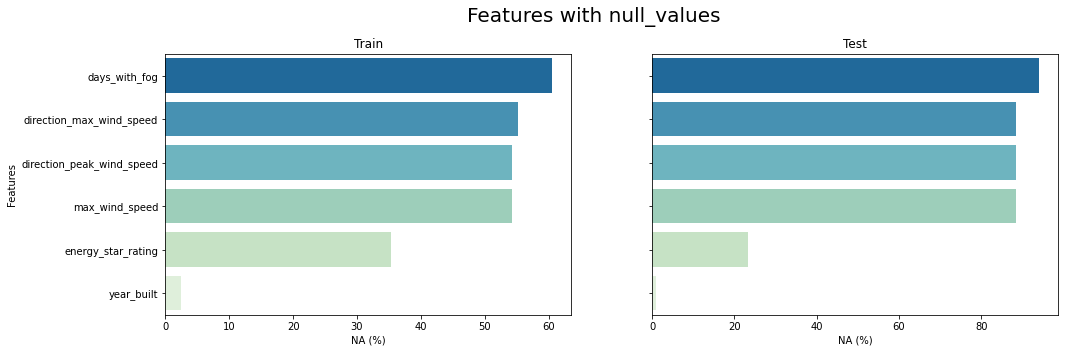

In [ ]:
def null_value_df(data):
    null_values_df = []
    for col in data.columns:

        if data[col].isna().sum() != 0:
            pct_na = np.round((100 * (data[col].isna().sum())/len(data)), 2)

            dict1 ={
                'Features' : col,
                'NA (count)': data[col].isna().sum(),
                'NA (%)': (pct_na)
            }
            null_values_df.append(dict1)
    return pd.DataFrame(null_values_df, index=None).sort_values(by='NA (count)',ascending=False)


df1 = null_value_df(train_df)
df2 = null_value_df(test_df)

fig, ax = plt.subplots(1,2, figsize=(16, 5), sharey=True)
fig.subplots_adjust(top=0.85)
# df1.plot.bar(y= 'Features', x='NA (%)',ax=ax[0],label='train')
sns.barplot(data=df1._to_pandas(), y= 'Features', x='NA (%)', ax= ax[0], label='train', palette='GnBu_r')
ax[0].set_title('Train')
sns.barplot(data=df2._to_pandas(), y= 'Features', x='NA (%)', ax =ax[1], label='test', palette='GnBu_r')
ax[1].set_title('Test')
ax[1].set_ylabel('')
plt.suptitle('Features with null_values ', fontsize=20);

### Categorical Features
- Year_factor : train data has 6 categories where as test data has only one (year_factot 7).
- State_factor : train data has 7 categories where as test data has 6. State_6 is only present in train data.
- Building_class : more commercial buildings in test data where as more residential buildings are present in train dataset.
- The feature facility_type is also not very similar in test and train datasets (unhide the second hidden cell below to see plot)

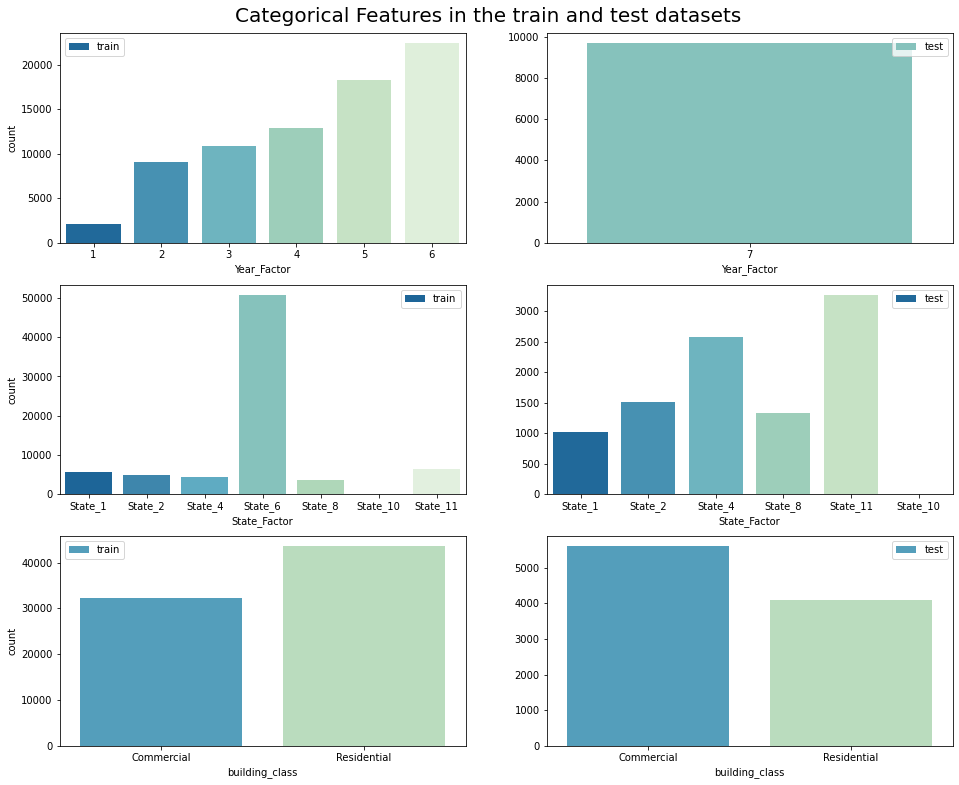

In [ ]:
fig, ax = plt.subplots(3,2, figsize=(16, 12), sharey=False)
fig.subplots_adjust(top=0.95)
sns.countplot(x=train_df['Year_Factor']._to_pandas(), label='train', ax = ax[0,0], palette='GnBu_r')
ax[0, 0].legend()
sns.countplot(x=test_df['Year_Factor']._to_pandas(), label='test', ax = ax[0,1], palette='GnBu_r')
ax[0,1].legend();
ax[0,1].set_ylabel('')
sns.countplot(x=train_df['State_Factor']._to_pandas(), label='train', ax = ax[1,0], palette='GnBu_r')
ax[1,0].legend();
sns.countplot(x=test_df['State_Factor']._to_pandas(), label='test', ax = ax[1, 1], palette='GnBu_r')
ax[1,1].legend();
ax[1,1].set_ylabel('')
sns.countplot(x=train_df['building_class']._to_pandas(), label='train', ax = ax[2,0], palette='GnBu_r')
ax[2,0].legend();
sns.countplot(x=test_df['building_class']._to_pandas(), label='test', ax = ax[2,1],palette='GnBu_r')
ax[2,1].legend();
ax[2,1].set_ylabel('')
plt.suptitle('Categorical Features in the train and test datasets ', fontsize=20);

### Categorical Features continued (Facility type)

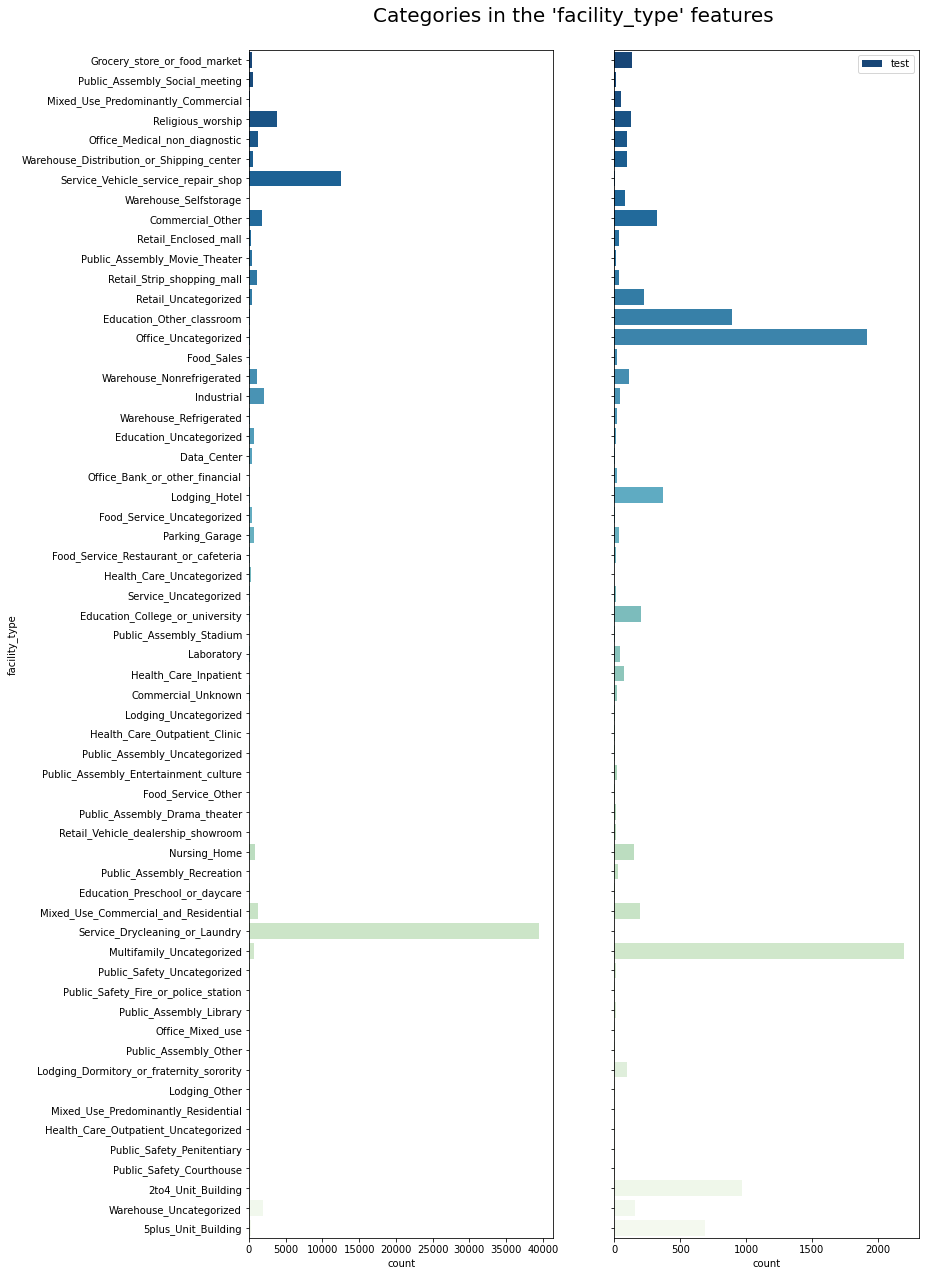

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12, 20), sharey=True)
fig.subplots_adjust(top=0.95)
sns.countplot(y=train_df['facility_type']._to_pandas(), label='train', ax = ax[0], palette='GnBu_r')
sns.countplot(y=test_df['facility_type']._to_pandas(), label='test', ax = ax[1], palette='GnBu_r')
ax[1].legend()
ax[1].set_ylabel('')
plt.suptitle("Categories in the 'facility_type' features", fontsize=20);

### Numerical Features (distribution)
(Gray facecolored plots are columns with NA values)
- Wind speed data has the largest disparity between train and test dataset distribution. These columns are also among thos which have NA's.

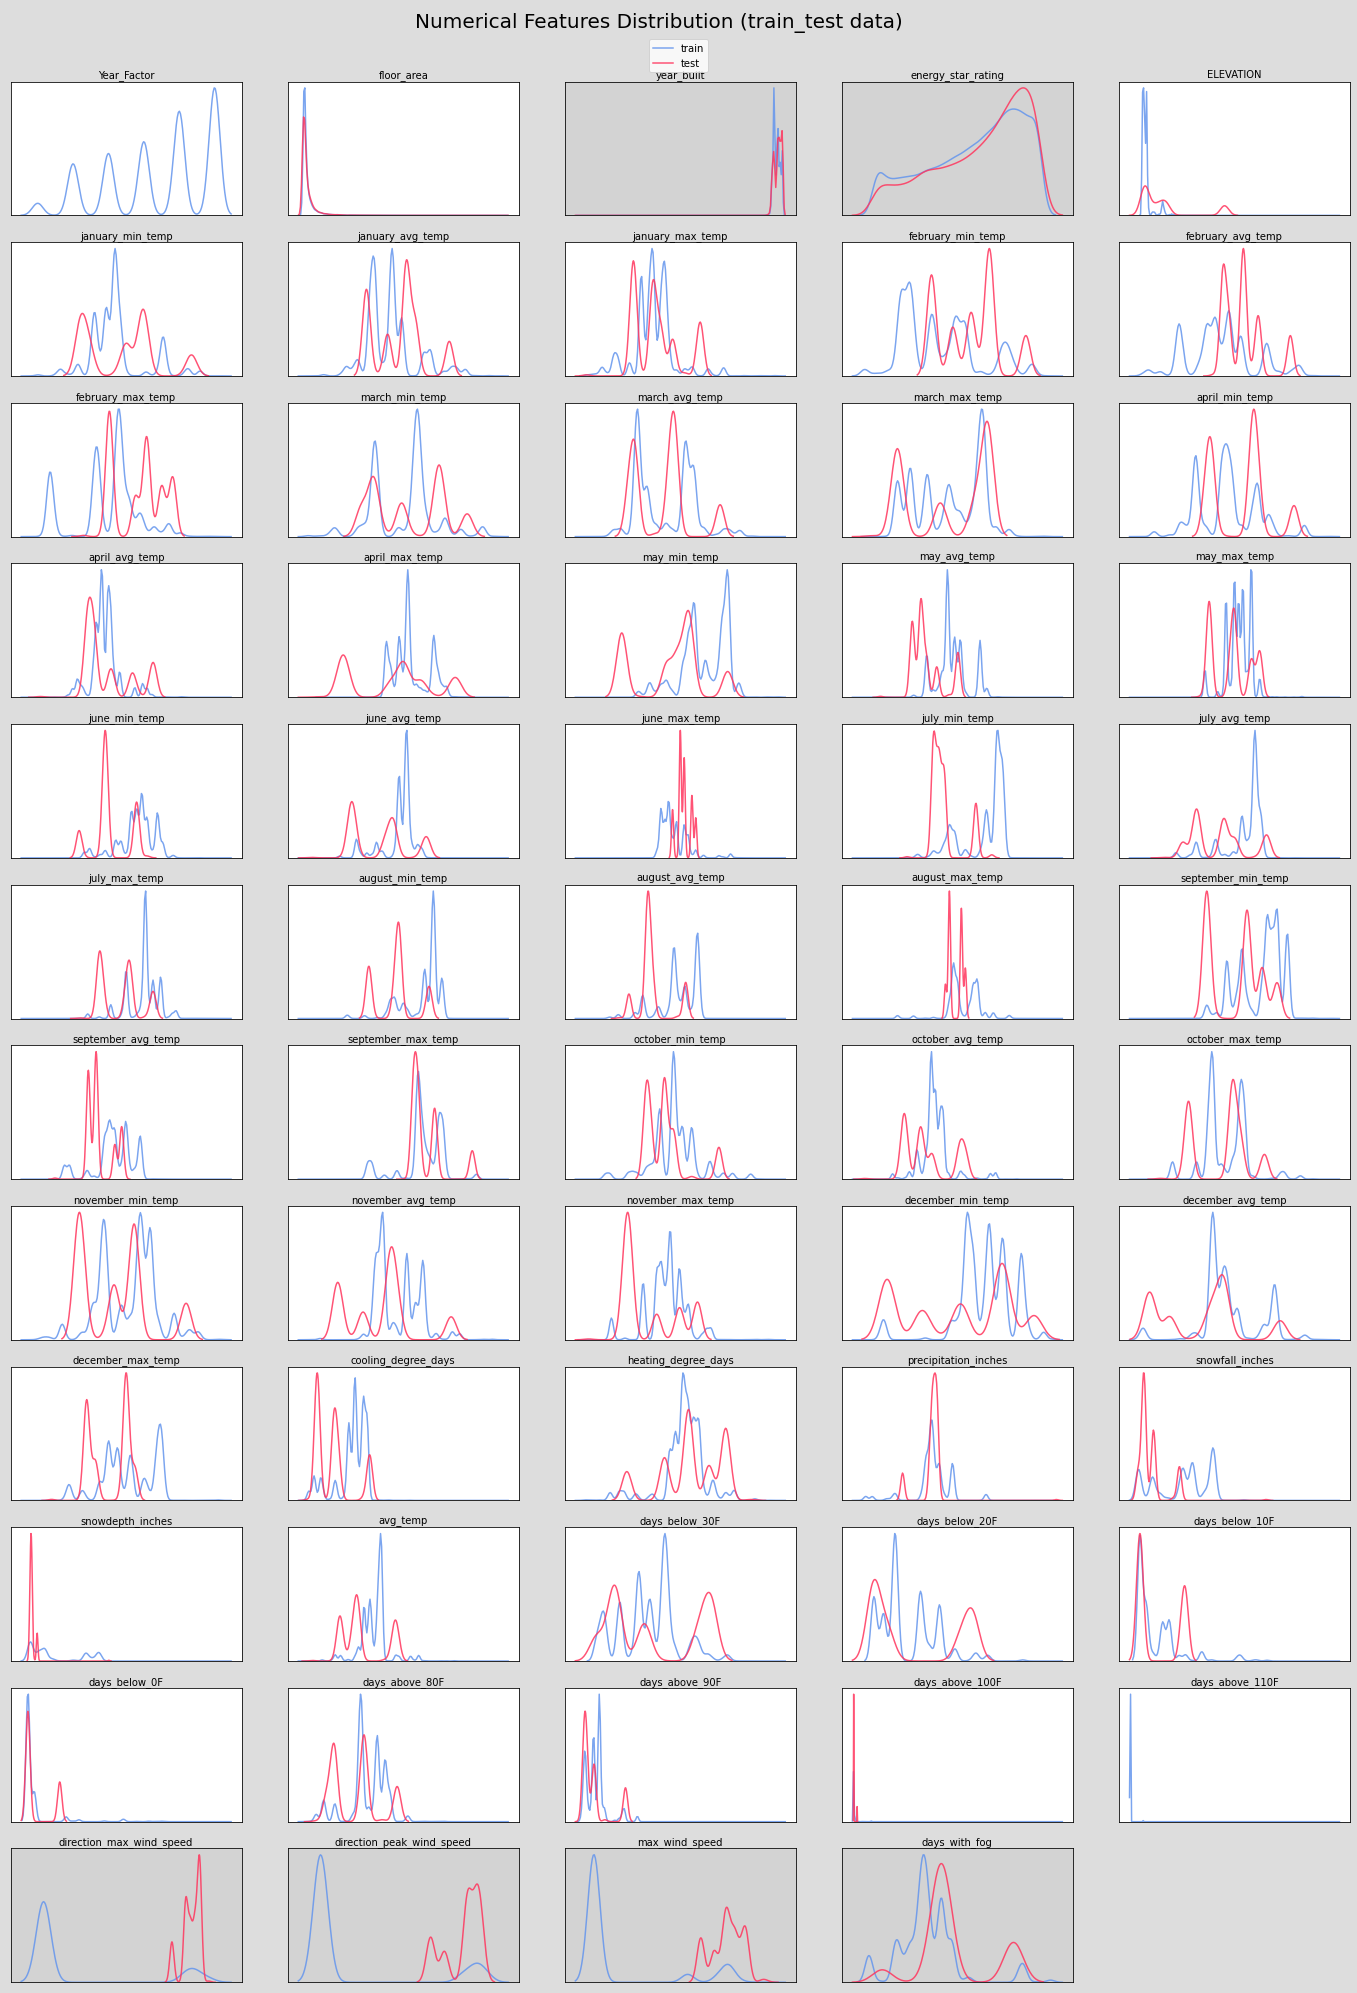

In [ ]:
cols_with_na= ['days_with_fog', 'direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'energy_star_rating', 'year_built']

def density_plot(train, test, features, title):

    L = len(features)
    ncol= 5
    nrow= int(np.ceil(L/ncol))
    remove_last= (nrow * ncol) - L

    fig, ax = plt.subplots(nrow, ncol,figsize=(24, 32), sharey=False, facecolor='#dddddd')
    ax.flat[-remove_last].set_visible(False)
    fig.subplots_adjust(top=0.95)
    i = 1
    for feature in features:
        plt.subplot(nrow, ncol, i)
        ax = sns.kdeplot(train[feature]._to_pandas(), shade=False,  color='#6495ED',  alpha=0.85, label='train')
        ax = sns.kdeplot(test[feature]._to_pandas(), shade=False, color='#ff355d',  alpha=0.85, label='test')
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
        ax.xaxis.set_label_position('top')
        ax.set_ylabel('')
        ax.set_yticks([])
        ax.set_xticks([])

        if feature in cols_with_na:

            ax.set_facecolor('lightgray')

        i += 1

    lines, labels = fig.axes[-1].get_legend_handles_labels()
    fig.legend(lines, labels, loc = 'upper center',borderaxespad= 4.0)

    plt.suptitle(title, fontsize=20)
    plt.show()

density_plot(train_df, test_df, num_features, title='Numerical Features Distribution (train_test data)');

### Correlations: Features vs Target plots
(Gray facecolored plots are columns with NA values)
- Floor area, day_above_90F, day_above_100F seem to be inversly related to site_eui

In [ ]:
facility_type = train_df.pop('facility_type')

features = train_df.columns
def mixed_subplots(data, features, titleText='Title', ncol=4):
    i = 1
    L = len(features)
    nrow= int(np.ceil(L/ncol))
    k = (nrow * ncol) - L

    fig, ax = plt.subplots(nrow, ncol, figsize=(24, 50), sharey=False)

    # this removes the last k (empty subplots)
    for j in range(1, k+1):
        ax.flat[-j].set_visible(False)
    #

    fig.subplots_adjust(top=0.96)

    for feature in features:
        plt.subplot(nrow, ncol, i)

        if data[feature].nunique() <= 10:
            ax = sns.boxplot(x=feature, y='site_eui', data= data._to_pandas(), color='gold')

        elif data[feature].nunique() < 20:
            ax = sns.barplot(x=feature, y='site_eui', data= data._to_pandas(), color='salmon')

        else:
            ax = sns.scatterplot(data=data._to_pandas(), x=feature, y='site_eui', color='lightseagreen')

        if feature in cols_with_na:

            ax.set_facecolor('lightgray')

        plt.xlabel(feature, fontsize=10)
        plt.grid()
        i += 1
    plt.suptitle(titleText, fontsize=20)
    plt.show()

train_df = pd.concat([train_df, facility_type], axis=1)

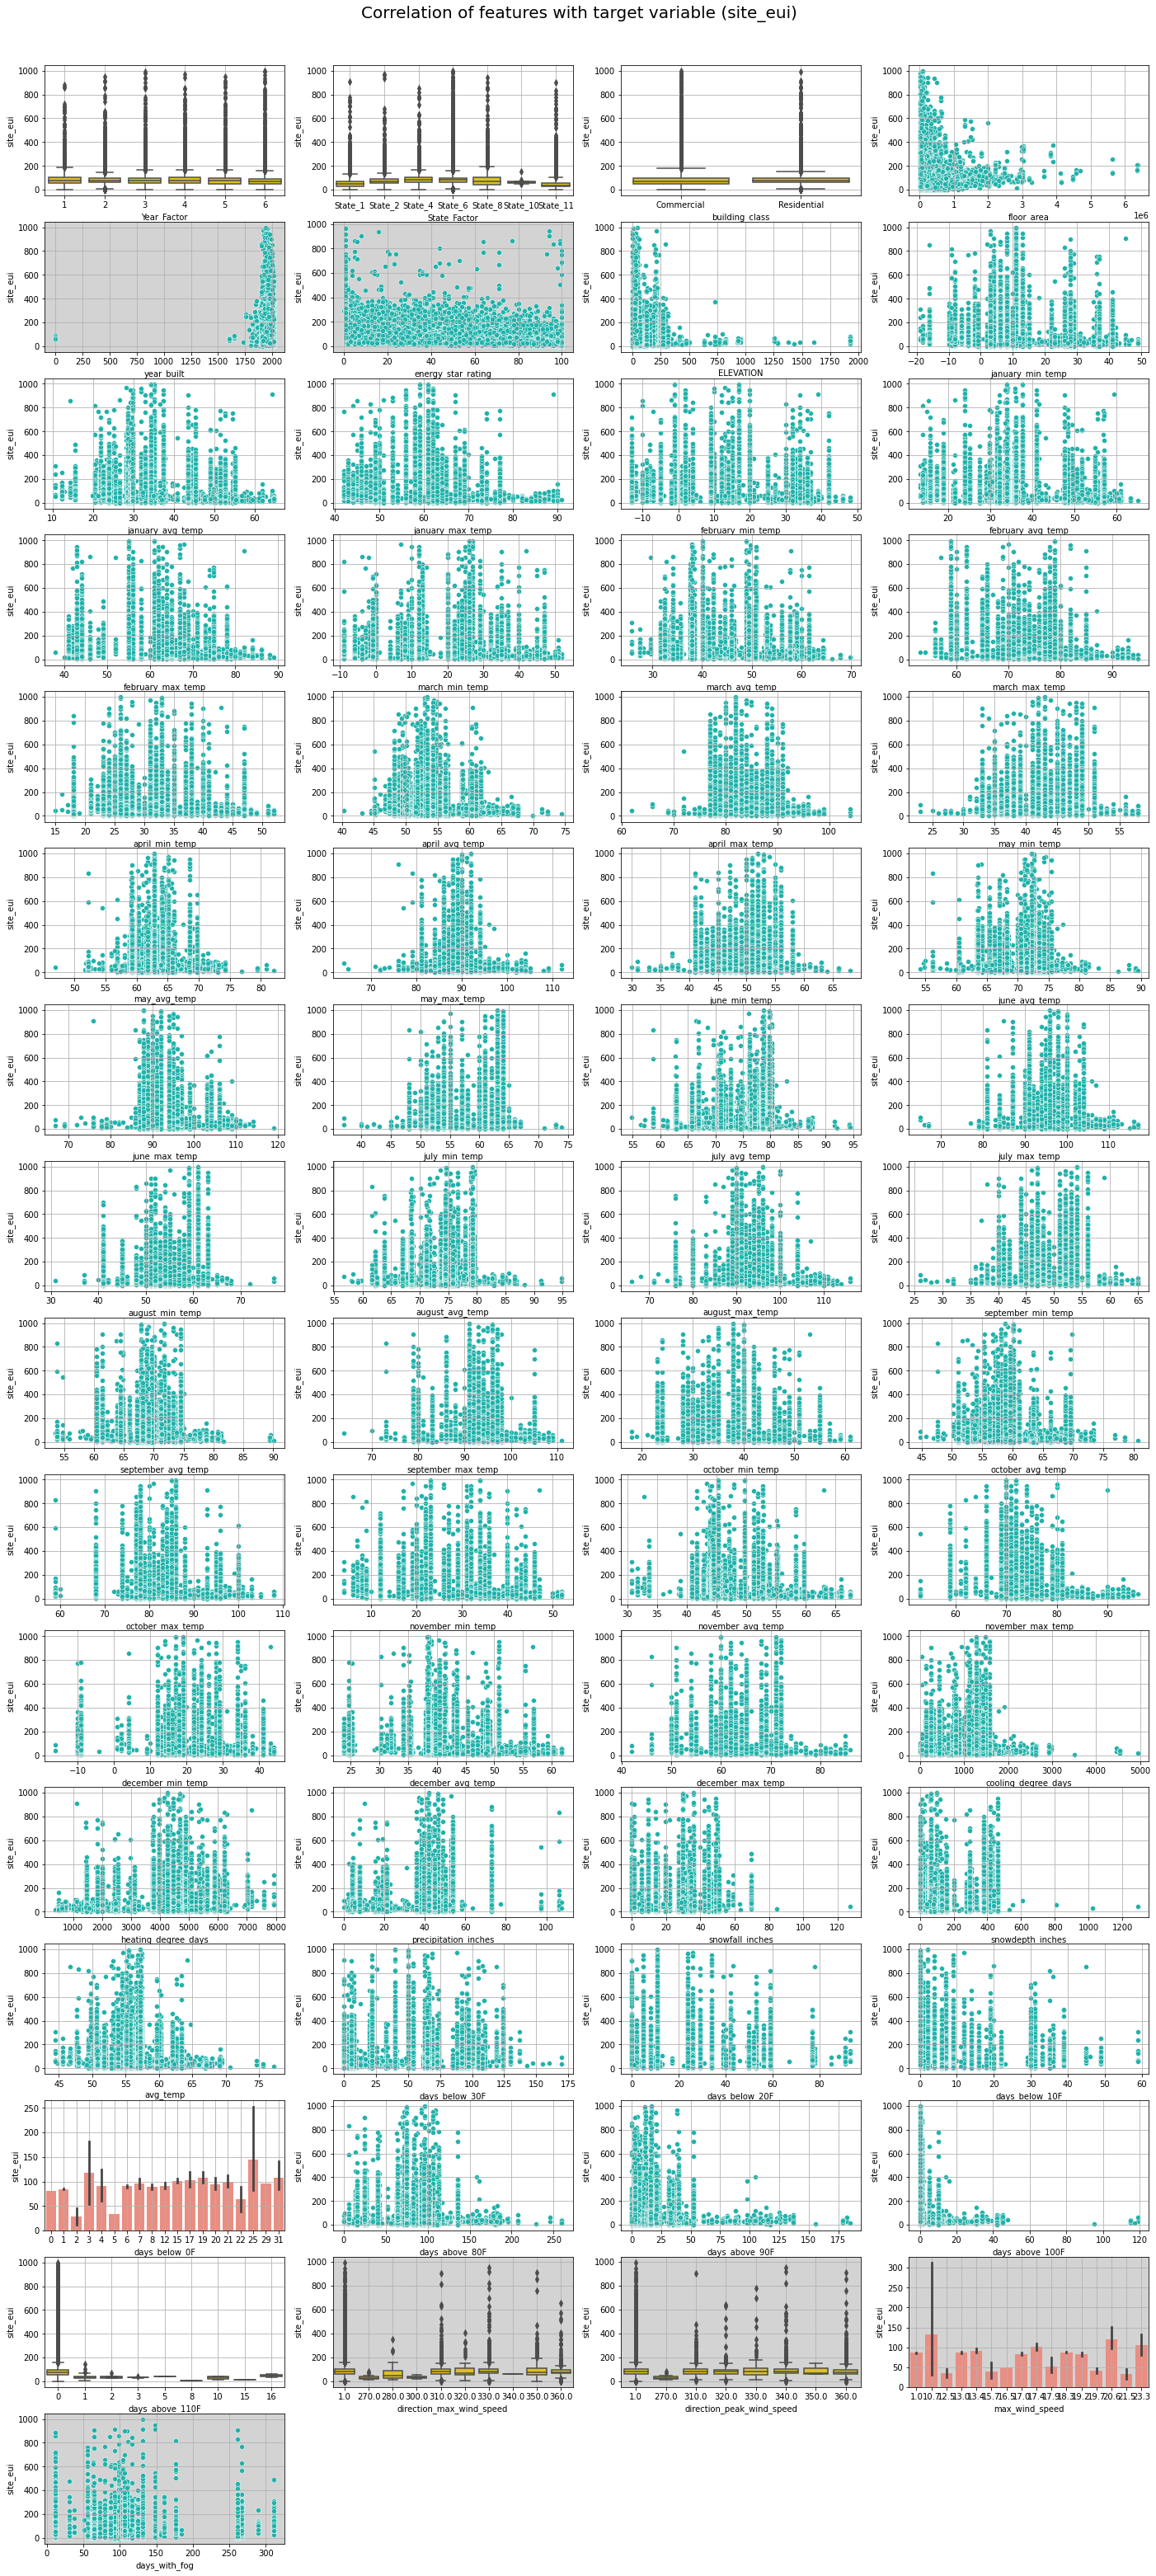

In [ ]:
titleText = "Correlation of features with target variable (site_eui)"
mixed_subplots(train_df, features[:-1], titleText, ncol=4)

### Correlations: Features vs Target plots (continued)
- On average, **grocery_store/food_market**, **data_centers**, and **laboratory** have higher site_eui (target values)

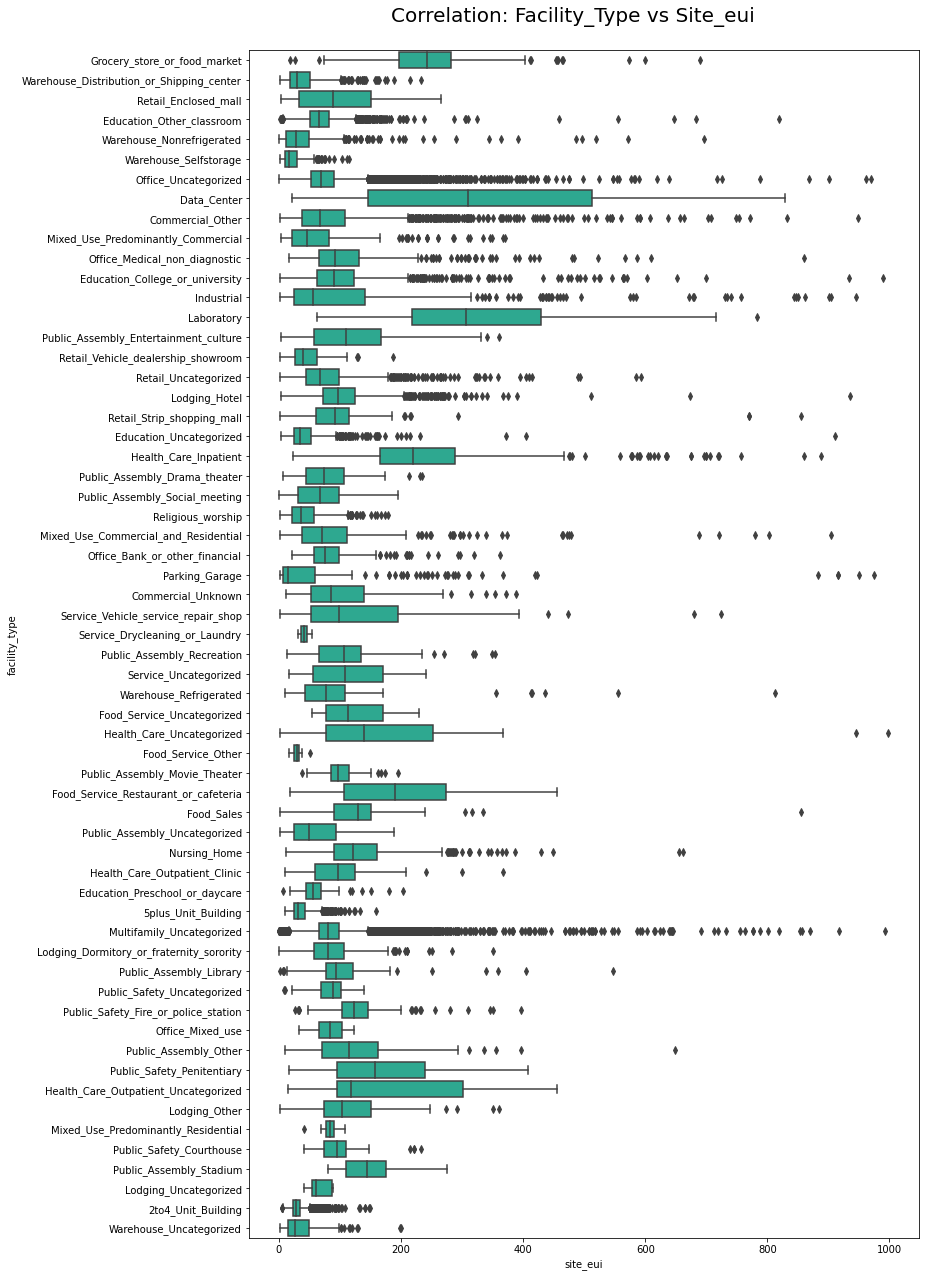

In [ ]:
fig, ax = plt.subplots(figsize=(12, 20), sharey=True)
fig.subplots_adjust(top=0.95)
sns.boxplot(y=facility_type._to_pandas(), x=train_df['site_eui']._to_pandas(), color='#1ABC9C')
plt.suptitle("Correlation: Facility_Type vs Site_eui", fontsize=20);

### Modeling
- Impute missing values
- Label Encoding categorical features
- Base model ``LBGMRegressor()`` and ``Catboost``
- Create submission file

In [ ]:
pip install -q scikit-learn-intelex

     |████████████████████████████████| 87 kB 5.4 MB/s 
     |████████████████████████████████| 26.0 MB 58.4 MB/s 
     |████████████████████████████████| 300.3 MB 15 kB/s 
     |████████████████████████████████| 4.0 MB 39.1 MB/s 


In [ ]:
pip install -q --upgrade dpcpp_cpp_rt

In [ ]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [ ]:
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
import gc

fold = 5
SEED = 42
EarlyStopping = 100

In [ ]:
!export SKLEARNEX_VERBOSE=INFO

### Target column

In [ ]:
y = train_df.pop('site_eui')

KeyError: ignored

### Label Encoding (cat features)

In [ ]:
# reminder what the  category features are
cat_features

['State_Factor', 'building_class', 'facility_type']

In [ ]:
cols_to_keep = [col for col in cat_features if set(train_df[col]) == set(test_df[col])]
cols_to_drop = list(set(cat_features) - set(cols_to_keep))

print('Categorical columns that will be label encoded:', cols_to_keep)
print('\nCategorical columns that will be dropped from the dataset:', cols_to_drop)

Categorical columns that will be label encoded: ['building_class', 'facility_type']

Categorical columns that will be dropped from the dataset: ['State_Factor']


In [ ]:
le = LabelEncoder()
def LE(train_df, test_df):
    for col in cols_to_keep:
        train_df[col] = le.fit_transform(train_df[col])
        test_df[col] = le.transform(test_df[col])
    return train_df, test_df

In [ ]:
train_df.drop(['State_Factor'], axis=1, inplace=True)
test_df.drop(['State_Factor'], axis=1, inplace=True)

In [ ]:
train_df, test_df = LE(train_df, test_df)

### Missing value imputation

In [ ]:
imputer = SimpleImputer()
imputed_train_df = pd.DataFrame(imputer.fit_transform(train_df))
imputed_test_df = pd.DataFrame(imputer.transform(test_df))

imputed_train_df.columns = train_df.columns
imputed_test_df.columns = test_df.columns

In [ ]:
train_df = imputed_train_df
test_df = imputed_test_df
train_df.head()

,Year_Factor,building_class,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,...,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,facility_type
0,1.0,0.0,61242.0,1942.0,11.0,2.4,36.0,50.5,68.0,35.0,...,0.0,14.0,0.0,0.0,0.0,1.0,1.000000,1.0,109.142051,13.0
1,1.0,0.0,274000.0,1955.0,45.0,1.8,36.0,50.5,68.0,35.0,...,0.0,14.0,0.0,0.0,0.0,1.0,62.779974,1.0,12.000000,55.0
2,1.0,0.0,280025.0,1951.0,97.0,1.8,36.0,50.5,68.0,35.0,...,0.0,14.0,0.0,0.0,0.0,1.0,62.779974,1.0,12.000000,48.0
3,1.0,0.0,55325.0,1980.0,46.0,1.8,36.0,50.5,68.0,35.0,...,0.0,14.0,0.0,0.0,0.0,1.0,62.779974,1.0,12.000000,6.0
4,1.0,0.0,66000.0,1985.0,100.0,2.4,36.0,50.5,68.0,35.0,...,0.0,14.0,0.0,0.0,0.0,1.0,1.000000,1.0,109.142051,56.0


### Base model (XGBoost)

In [ ]:
gc.enable()

kfold = KFold(n_splits=fold, shuffle=True, random_state=SEED)
oof_preds = np.zeros(train_df.shape[0])
subm_preds_xgb = np.zeros(test_df.shape[0])

features = train_df.columns

for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(train_df)):
    trn_x, trn_y = train_df[features].iloc[trn_idx], y.iloc[trn_idx]
    val_x, val_y = train_df[features].iloc[val_idx], y.iloc[val_idx]

    xgb = XGBRegressor()

    xgb.fit(trn_x, trn_y,
           eval_set =[(trn_x, trn_y), (val_x, val_y)],
           eval_metric="rmse", verbose=0, early_stopping_rounds = EarlyStopping
           )
    oof_preds[val_idx] = xgb.predict(val_x)
    subm_preds_xgb += xgb.predict(test_df[features])/kfold.n_splits

    print('Fold {} RMSE : {:.6f}'.format(n_fold + 1, mean_squared_error(val_y, oof_preds[val_idx], squared=False)))

    del xgb, trn_x, trn_y, val_x, val_y
    gc.collect()

[17:32:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fold 1 RMSE : 45.558602
[17:33:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fold 2 RMSE : 42.672146
[17:33:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fold 3 RMSE : 46.247498
[17:33:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fold 4 RMSE : 46.408240
[17:33:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fold 5 RMSE : 45.399997


In [ ]:
print("\n")
print('XGBoost {} fold average RMSE score is: {:.6f}'.format(fold, (mean_squared_error(y, oof_preds, squared=False))))



LGBM 5 fold average RMSE score is: 45.277368


### Base model (Catboost)

In [ ]:
gc.enable()

kfold = KFold(n_splits=fold, shuffle=True, random_state=SEED)
oof_preds = np.zeros(train_df.shape[0])
subm_preds_reg = np.zeros(test_df.shape[0])

features = train_df.columns

for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(train_df)):
    trn_x, trn_y = train_df[features].iloc[trn_idx], y.iloc[trn_idx]
    val_x, val_y = train_df[features].iloc[val_idx], y.iloc[val_idx]

    reg = RandomForestRegressor(random_state=0, verbose=1)

    reg.fit(trn_x, trn_y)
    oof_preds[val_idx] = reg.predict(val_x)
    subm_preds_reg += reg.predict(test_df[features])/kfold.n_splits

    print('Fold {} RMSE : {:.6f}'.format(n_fold + 1, mean_squared_error(val_y, oof_preds[val_idx], squared=False)))

    del reg, trn_x, trn_y, val_x, val_y
    gc.collect()

Fold 1 RMSE : 42.009091
Fold 2 RMSE : 41.617577
Fold 3 RMSE : 42.958767
Fold 4 RMSE : 42.504944
Fold 5 RMSE : 42.967012


In [ ]:
print("\n")
print('Random Forest Regressor {} fold average RMSE score is: {:.6f}'.format(fold, (mean_squared_error(y, oof_preds, squared=False))))



Random Forest Regressor 5 fold average RMSE score is: 42.414785


# Intel Tensorflow

In [ ]:
pip install -q intel-tensorflow==2.9.1

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
print ("We are using Tensorflow version", tf.__version__)

We are using Tensorflow version 2.9.1


In [ ]:
!export ONEDNN_VERBOSE=1

In [ ]:
gc.enable()

kfold = KFold(n_splits=fold, shuffle=True, random_state=SEED)
oof_preds = np.zeros(train_df.shape[0])
subm_preds_tf = np.zeros(test_df.shape[0])

features = train_df.columns

for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(train_df)):
    trn_x, trn_y = np.array(train_df[features].iloc[trn_idx]), np.array(y.iloc[trn_idx])
    val_x, val_y = np.array(train_df[features].iloc[val_idx]), np.array(y.iloc[val_idx])

    model = keras.Sequential([
        layers.Dense(128, input_dim=61, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    model.compile(loss='mean_squared_error',
                  optimizer=tf.keras.optimizers.Adam(0.001))

    model.fit(trn_x, trn_y, batch_size=128, verbose=1, epochs=1)
    oof_preds[val_idx] = model.predict(val_x).squeeze()
    subm_preds_tf += model.predict(np.array(test_df[features])).squeeze()/kfold.n_splits

    print('Fold {} RMSE : {:.6f}'.format(n_fold + 1, mean_squared_error(val_y, oof_preds[val_idx], squared=False)))

    del model, trn_x, trn_y, val_x, val_y
    gc.collect()

304/304 [==============================] - 1s 2ms/step
Fold 1 RMSE : 60.255579
304/304 [==============================] - 0s 1ms/step
Fold 2 RMSE : 67.107478
304/304 [==============================] - 0s 1ms/step
Fold 3 RMSE : 61.651603
304/304 [==============================] - 0s 2ms/step
Fold 4 RMSE : 61.692370
304/304 [==============================] - 1s 2ms/step
Fold 5 RMSE : 82.925010


In [ ]:
import numpy as np
N=10000
A = np.random.randn(N, N)
X = np.random.randn(N)

def naive(A, X):
    Y = np.zeros(A.shape[1])
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            Y[j] += A[i, j]*X[i]
    return Y

%timeit naive(A, X)
%timeit np.dot(A, X)
%timeit np.matmul(A, X)
%timeit np.inner(A, X)
%timeit np.tensordot(A, X, axes=1)

1 loop, best of 5: 47.5 s per loop
100 loops, best of 5: 16.8 ms per loop
100 loops, best of 5: 16.9 ms per loop
100 loops, best of 5: 16.9 ms per loop
100 loops, best of 5: 17.1 ms per loop
